# Simple Exponential Smoothing

In [1]:
# Qui scarichiamo il file sugli airline passengers, ovviamente sempre per windows l'abbiamo dovuto fa manualmente
# Il dataset in questione è quello didattico (equivalente del MNIST per la handwritten recognition) per le time-series
"""
Perchè usiamo questo dataset e non gli stock prices?
Perchè usiamo uno dei principi del ML, dove gli algoritmi vedono i dati come "la stessa cosa". Cambiando dataset
non cambia l'algoritmo, al massimo cambiano iperparametri. Adatteremo le cose ai valori che servono più in là.
Usiamo questo dataset perchè, a differenza dello stock price che si basa sulla efficient market hypotesis, l'analisi di queste
serie temporali con le tecniche che stiamo per vedere richiede una struttura della serie che è più facile riscontrare in questo
dataset rispetto allo stock price.
""";

In [2]:
import pandas as pd
import numpy as np

pd.options.mode.copy_on_write = True

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [3]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [4]:
# N.B.: questi sono dati mensili, non giornalieri. Con index_col = "Day" non troviamo niente.
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# Che bel dataset, non ha NaNs.
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

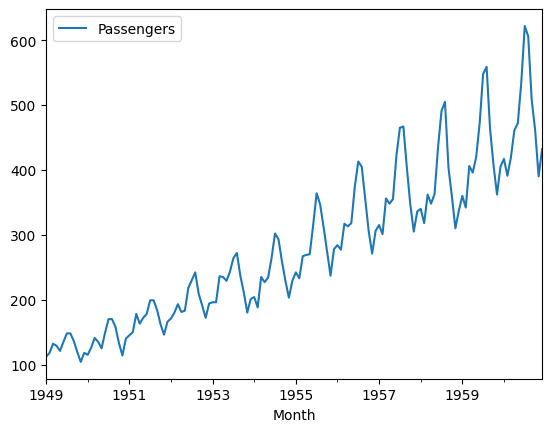

In [6]:
"""
Considerazioni sul plot: Notare come ci sia ben poca "randomicità" in questo modello. E' differente da quello che è un modello
Stock Price dove invece si vede molto "random". Questo è un trend che si ripete, con un aumento.
Una serie del genere è ottima per l'uso del machine learning, a differenza di dataset ad alta randomicità.
Questo grafico ha un PATTERN:
C'è una componente trend (aumento) ed una ciclica (i "denti" del chart, una componente che si ripete).
Il pattern ciclico aumenta nel tempo. Non si comprende bene il tipo di aumento. Inoltre ancora non si conosce il modello che rappresenta il trend,
non si sa se è lineare o esponenziale.
Molti eventi del mondo reale si comportano in realtà come esponenziali. Vedi legge di Moore per la potenza di calcolo o la trasmissione virale.
Tuttavia c'è da comprendere che esistono dei limiti (ad esempio poplazione finita) che ad un certo punto stoppano il trend esponenziale, facendolo
diventare una sigmoide.
""";
df.plot()

In [7]:
# Scegliamo Alpha con valore 0.2. Non c'è nessun motivo per scegliere questo valore. Alpha è un iperparametro
alpha = 0.2

In [8]:
# Usando adjust=False usiamo il metodo che abbiamo visto nella teoria, ossia ricorsivamente. 
# Con adjust=True calcoliamo usando tutti i valori
# ATTENZIONE: è importante settare alpha usando il named parameter altrimenti non lo prende
df["EWMA"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

In [9]:
type(df["Passengers"].ewm(alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

<Axes: xlabel='Month'>

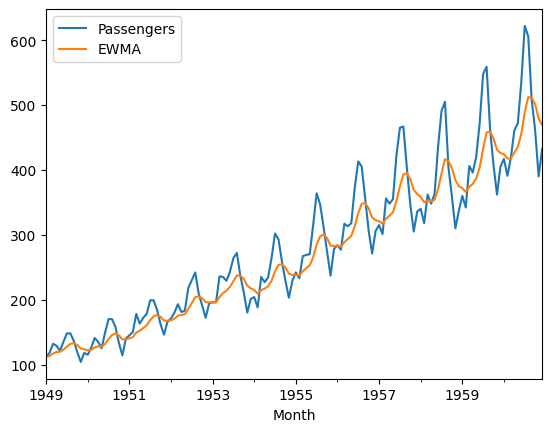

In [10]:
"""
Considerazioni sul plot:
Notiamo come effettivamente sia molto simile alla SMA, è una versione più addolcita e in delay del trend.
Aumentando Alpha diventa più vicina al valore reale (jagged chart), altrimenti diventa ancora più dolce
"""
df.plot()

In [11]:
# Calcoliamo manualmente:
manual_ewma = []
for x in df["Passengers"].to_numpy():
    if len(manual_ewma) > 0:
        new_value = x*alpha + manual_ewma[-1]*(1-alpha)
        manual_ewma.append(new_value)
    else:
        # Inizializzazione della EWMA: generalmente si usa 0 come primo valore. Tuttavia portare da 100+ a 0 induce un bias
        # Questo bias si corregge con determinati metodi (ad esempio come accade in ADAM), tuttavia qui ci limitiamo a copiare il primo valore.
        # La media di un valore, in effetti, è il valore stesso.
        manual_ewma.append(x)
df["manual_ewma"] = manual_ewma

<Axes: xlabel='Month'>

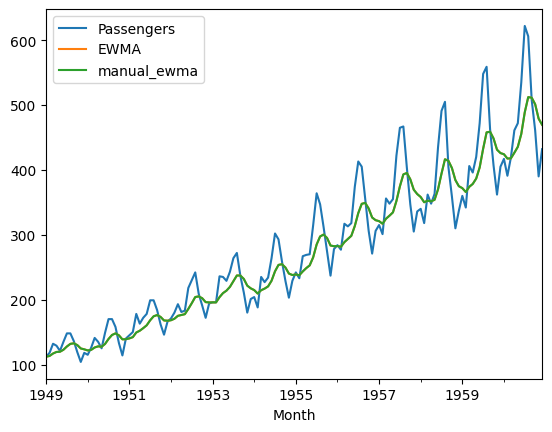

In [12]:
df.plot()

In [13]:
df.drop("manual_ewma", axis=1, inplace=True)

In [14]:
"""
Pandas by default non assegna una frequenza agli indici. Per questo motivo, quando chiamiamo il metodo nudo e crudo, otteniamo
un warning. Lo possiamo vedere se printiamo l'indice del dataframe.
""";
ses = SimpleExpSmoothing(df["Passengers"])

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
# Qui freq=None
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [16]:
"""
Possiamo assegnare molto facilmente una frequenza all'indice. Questo qui è un indice date range, ed esistono diverse
stringhe che si possono associare agli indici temporali.
Ci sono più dettagli qui: https://pandas.pydata.org/docs/user_guide/timeseries.html
Assegnando noi la frequenza ad MS, indichiamo che la frequenza è mensile. Al link sopra ci sono le varie stringhe.
"""
df.index.freq = "MS"

In [17]:
ses = SimpleExpSmoothing(df["Passengers"])

In [18]:
results = ses.fit(smoothing_level=alpha, optimized=False)

In [19]:
results

In [20]:
# Predict ritorna una series pandas.
results.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [21]:
df["SES"] = results.predict(start=df.index[0], end=df.index[-1])

In [22]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [23]:
"""
Ora dimostriamo come i valori predetti da SES sul training set siano uguali all'attributo fittedvalues di results.
Per farlo usiamo la funzione np.allclose() che, date due serie, restituirà True se sono uguali
"""
np.allclose(df["SES"], results.fittedvalues)

True

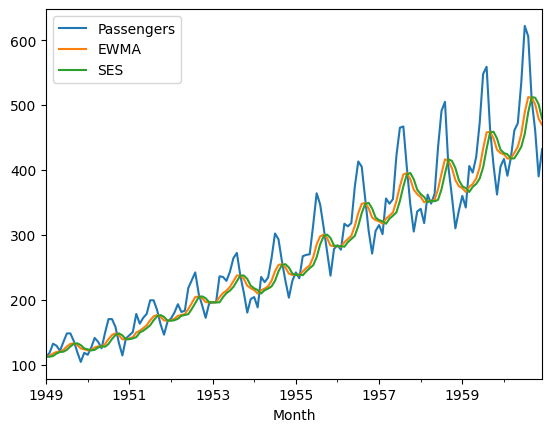

In [24]:
# Sia dal df.head sopra, sia dal plot, notiamo come ci sia uno shift di uno sui valori predetti.
df.plot();

In [25]:
# Allora shiftiamo, anche se vedremo che E' UN GRANDE ERRORE
df["SES-1"] = df["SES"].shift(-1)

## Grande attenzione al plot sotto!

Quello che stiamo creando qui non è tanto un modello di smoothing average, quanto un modello di forecast!!!
La teoria dice chiaramente che noi prediciamo $x_{t+1}$ sulla base di $l_t$, dove $l_t$ è il livello al tempo t calcolato come exponential moving average. In poche parole, al tempo t+1, prediciamo il valore precedente. Questo è il reale motivo per il quale vediamo uno shift a destra!!

In poche parole il plot sotto è **sbagliato** ed è giusto quello sopra

La correzione avverrà quando vedremo il modello Holt-Winters, dove non sarà necessario shiftare nulla

<Axes: xlabel='Month'>

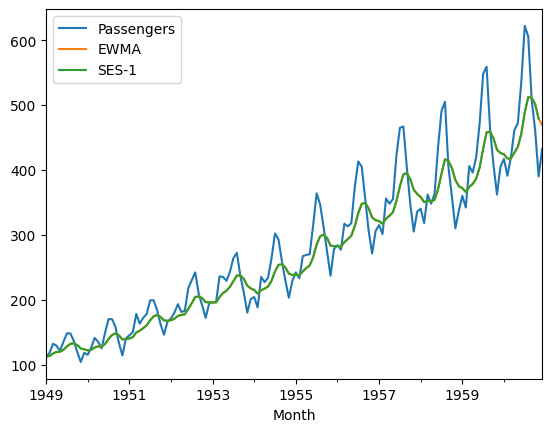

In [26]:
df[["Passengers", "EWMA", "SES-1"]].plot()

## Tests

Trattiamo il problema come un machine learning: fittiamo il modello su alcuni dati e usiamo il resto (test set) per verificare il forecast

In [27]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [28]:
ses = SimpleExpSmoothing(train["Passengers"])

In [29]:
# results = ses.fit(smoothing_level=alpha, optimized=False) -> No, questa volta facciamo fittare alpha a lui
results = ses.fit()

In [30]:
"""
df.loc[:-N_test, "SESfitted"] = results.fittedvalues
df.loc[-N_test:,"SESfitted"] = results.forecast(N_test)
NON FUNZIONANO, QUINDI ALTERNIAMO
"""
np_array_results = np.r_[results.fittedvalues, results.forecast(N_test)]

In [31]:
df["SESfitted"] = np_array_results

### Alcune considerazioni

In primo luogo, possiamo notare che ciò che abbiamo prodotto come modello questa volta (tramite fit) reagisce molto molto rapidamente ai cambiamenti dei dati. Questo ci fa intuire (e lo vediamo giù) che l'alpha che ha appreso è molto vicino ad 1, infatti sembra una copia laggata dei dati.
In secondo luogo, come dovevamo immaginare, dato che $\hat{x}_{t+h} = l_t$  $\forall h > 0$. Questo ci produce una linea diritta come risultato del forecast.

Altra considerazione riguarda la questione shifting. Se noi shiftassimo di uno indietro, ci basta modellare il vecchio valore e questo diventa il forecast perfetto. Questo, filosoficamente, ha poco senso. Possiamo dire che effettivamente l'ultimo valore noto è il miglior forecast di questa serie temporale (QUESTA, che ha TREND + CICLICITA'?). Ovviamente dovremmo modellare trend e ciclicità ancora, quindi c'è altro lavoro da fare. A fine di ciò, avremo ogni cosa al suo posto


<Axes: xlabel='Month'>

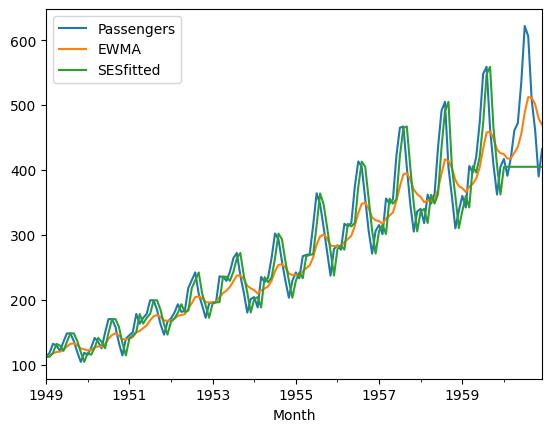

In [32]:
df[["Passengers", "EWMA", "SESfitted"]].plot()

In [33]:
results.params

{'smoothing_level': np.float64(0.995),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(112.0),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# Holt Linear Model

In [34]:
from statsmodels.tsa.holtwinters import Holt

In [35]:
holt_model = Holt(df["Passengers"])

In [36]:
# Non passiamo nessun valore, anche se è possibile impostare alpha e beta
results_holt = holt_model.fit() 

In [37]:
df["Holt"] = results_holt.fittedvalues

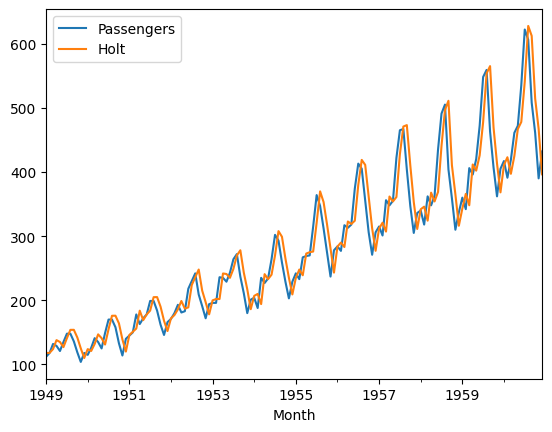

In [38]:
"""
Anche in questo caso il plot sembrerà storto e shiftato. Dobbiamo resistere alla tentazione di shiftarlo, ci saranno modelli in grado di prevedere l'andamento in maniera lineare. 
Se shiftiamo, dovremmo shiftare anche quei modelli e, a quel punto, il modello avanzato risulterà fittare male
"""
df[["Passengers", "Holt"]].plot();

In [39]:
# Ora rifacciamo le stesse predizioni, ma con il train ed il test.
holt_model = Holt(train["Passengers"])
holt_results = holt_model.fit();

In [40]:
holt_fitted = holt_results.fittedvalues
holt_predicted = holt_results.forecast(N_test)
holt_total = np.r_[holt_fitted, holt_predicted]

In [41]:
df["HoltFitted"] = holt_total

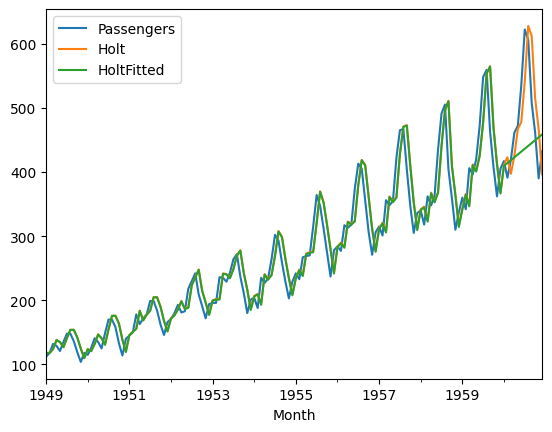

In [42]:
df[["Passengers", "Holt", "HoltFitted"]].plot();

In [43]:
# Notiamo come alpha è praticamente 1, ma abbiamo uno smoothing trend (beta) che è maggiore di 0
holt_model.params

{'smoothing_level': np.float64(0.9999999850988388),
 'smoothing_trend': np.float64(0.003950276278561975),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(112.0),
 'initial_trend': np.float64(6.0),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# Holt-Winters Model

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Modello Additivo totale

In [45]:
holtwinters = ExponentialSmoothing(df["Passengers"], trend="add", seasonal="add", seasonal_periods=12)

In [46]:
hw_results = holtwinters.fit()

In [47]:
df["HoltWinters"] = hw_results.fittedvalues

<Axes: xlabel='Month'>

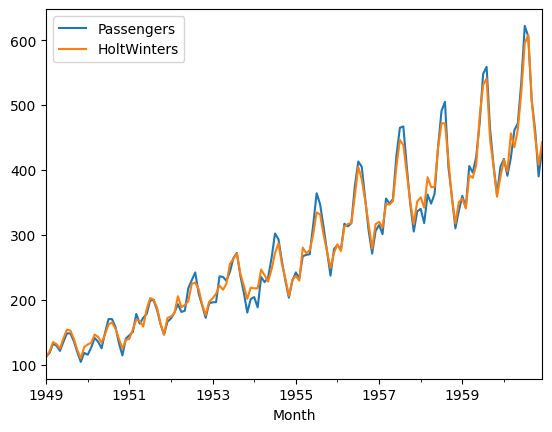

In [48]:
# WOW, molto più bello, e senza necessità di forecast!
df[["Passengers", "HoltWinters"]].plot()

In [49]:
holtwinters.params

{'smoothing_level': np.float64(0.25254071471067646),
 'smoothing_trend': np.float64(7.496251518237956e-10),
 'smoothing_seasonal': np.float64(0.747459281696295),
 'damping_trend': nan,
 'initial_level': np.float64(118.42688725548278),
 'initial_trend': np.float64(2.594907264644525),
 'initial_seasons': array([ -9.01481077,  -3.46568743,   9.02623016,   3.78592714,
         -4.95366095,   9.14399847,  21.32163074,  18.86386982,
          4.64978962, -14.27055939, -28.89736849, -12.52756085]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [50]:
holtwinters = ExponentialSmoothing(train["Passengers"], trend="add", seasonal="add", seasonal_periods=12)
hw_results = holtwinters.fit()

In [51]:
hw_fitted = hw_results.fittedvalues
hw_predicted = hw_results.forecast(N_test)
hw_all = np.r_[hw_fitted, hw_predicted]
df["HoltWintersFitted"] = hw_all

<Axes: xlabel='Month'>

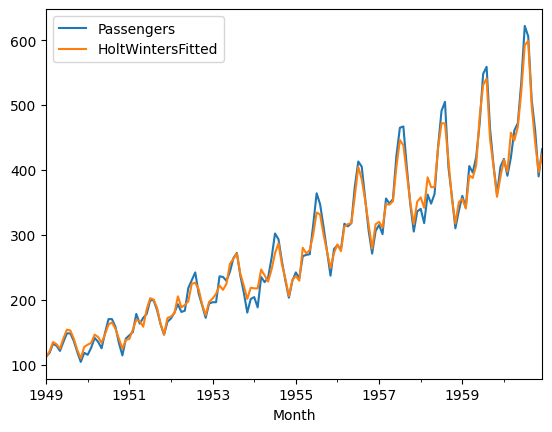

In [52]:
df[["Passengers", "HoltWintersFitted"]].plot()

### Modello Moltiplicativo sulla season

In [53]:
holtwinters_mul = ExponentialSmoothing(train["Passengers"], trend="add", seasonal="mul", seasonal_periods=12)
hw_results_mul = holtwinters_mul.fit()

In [54]:
hw_fitted_mul = hw_results_mul.fittedvalues
hw_predicted_mul = hw_results_mul.forecast(N_test)
hw_all_mul = np.r_[hw_fitted_mul, hw_predicted_mul]
df["HoltWintersFittedMul"] = hw_all_mul

<Axes: xlabel='Month'>

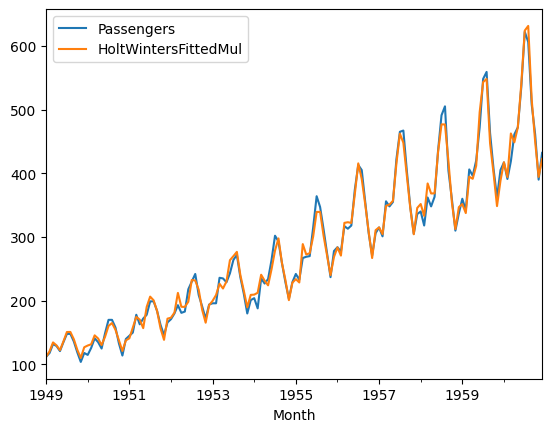

In [55]:
df[["Passengers", "HoltWintersFittedMul"]].plot()

### Modello Moltiplicativo totale

In [56]:
holtwinters_allmul = ExponentialSmoothing(train["Passengers"], trend="mul", seasonal="mul", seasonal_periods=12)
hw_results_allmul = holtwinters_allmul.fit()

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [57]:
hw_fitted_allmul = hw_results_allmul.fittedvalues
hw_predicted_allmul = hw_results_allmul.forecast(N_test)
hw_all_allmul = np.r_[hw_fitted_allmul, hw_predicted_allmul]
df["HoltWintersFittedAllMul"] = hw_all_allmul

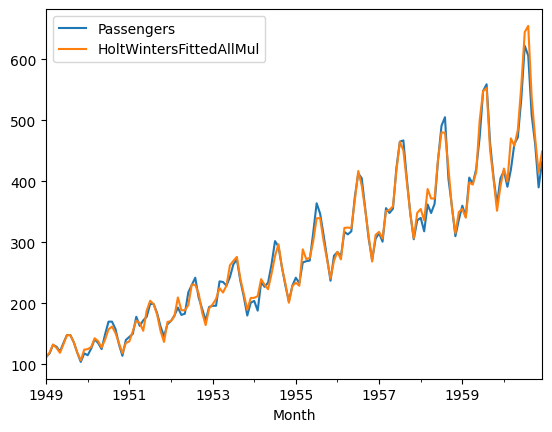

In [58]:
df[["Passengers", "HoltWintersFittedAllMul"]].plot();

## Valutando i tre modelli

In [59]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y- y_hat)**2))

In [60]:
def mae(y, y_hat):
    return np.mean(np.abs((y- y_hat)))

#### Additive

In [61]:
print(f"train rmse: {rmse(train["Passengers"], hw_fitted)}, train mae: {mae(train["Passengers"], hw_fitted)}")
print(f"test rmse: {rmse(test["Passengers"], hw_predicted)}, test mae: {mae(test["Passengers"], hw_predicted)}")

train rmse: 11.624718494508544, train mae: 9.007841831511017
test rmse: 16.979968673445825, test mae: 13.380404629233752


#### Season Multiplicative

In [62]:
print(f"train rmse: {rmse(train["Passengers"], hw_fitted_mul)}, train mae: {mae(train["Passengers"], hw_fitted_mul)}")
print(f"test rmse: {rmse(test["Passengers"], hw_predicted_mul)}, test mae: {mae(test["Passengers"], hw_predicted_mul)}")

train rmse: 9.768019112679353, train mae: 7.604241071575623
test rmse: 15.809562602748581, test mae: 10.302260794882585


#### Trend + Season Multiplicative

In [63]:
print(f"train rmse: {rmse(train["Passengers"], hw_fitted_allmul)}, train mae: {mae(train["Passengers"], hw_fitted_allmul)}")
print(f"test rmse: {rmse(test["Passengers"], hw_predicted_allmul)}, test mae: {mae(test["Passengers"], hw_predicted_allmul)}")

train rmse: 9.61792556825461, train mae: 7.1123826896479745
test rmse: 25.797186073558986, test mae: 20.83580205712619
